In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/kaggle/input/coffee-sales-dataset/Coffe_sales.csv


In [ ]:
df= pd.read_csv("Coffe_sales.csv")

In [3]:
df.shape

(3547, 11)

In [4]:
df.head()

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


In [6]:
df.isnull().sum()

hour_of_day    0
cash_type      0
money          0
coffee_name    0
Time_of_Day    0
Weekday        0
Month_name     0
Weekdaysort    0
Monthsort      0
Date           0
Time           0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hour_of_day,3547.0,14.185791,4.234010,6.00,10.00,14.00,18.00,22.0
money,3547.0,31.645216,4.877754,18.12,27.92,32.82,35.76,38.7
Weekdaysort,3547.0,3.845785,1.971501,1.00,2.00,4.00,6.00,7.0
Monthsort,3547.0,6.453905,3.500754,1.00,3.00,7.00,10.00,12.0


<Axes: >

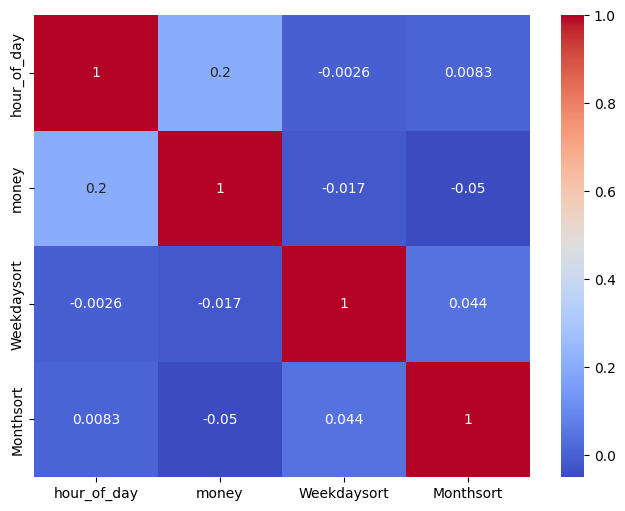

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap="coolwarm")

In [9]:
X = df.drop("money",axis=1)
y = df["money"]

In [10]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [12]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [14]:
models = {
    "LinearRegression" : LinearRegression(),
    "RandomForest" : RandomForestRegressor(n_estimators=100, random_state=15),
    "GradientBoosting" : GradientBoostingRegressor(n_estimators=100, random_state=15)
}


,Model,RMSE,MAE,R2
0,LinearRegression,0.265088,0.086249,0.997082
1,RandomForest,0.569226,0.147939,0.986548
2,GradientBoosting,0.650764,0.403156,0.982418


Text(0.5, 1.0, 'Model Karşılaştırılması')

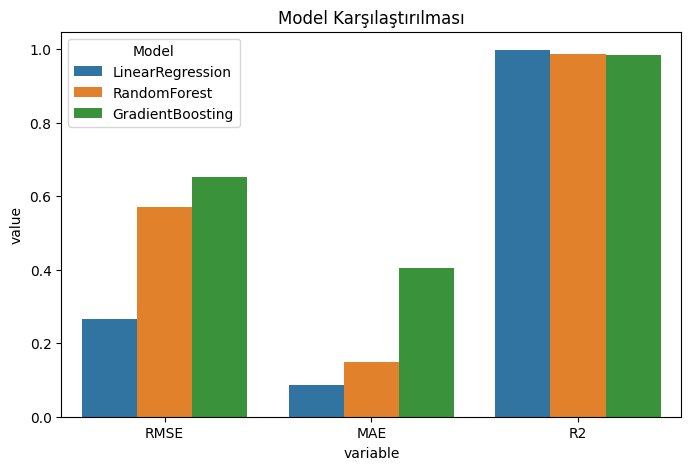

In [15]:
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor",preprocessor),
                           ("model",model)])
    pipe.fit(X_train,y_train)
    y_pred=pipe.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2})

results_df = pd.DataFrame(results)
display(results_df)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df.melt(id_vars="Model", value_vars=["RMSE","MAE","R2"]),
           x="variable", y="value", hue="Model")

plt.title("Model Karşılaştırılması")

In [16]:
rf_pipe = Pipeline(steps=[("preprocessor",preprocessor),
                           ("model",model)])

In [17]:
rf_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

In [18]:
rf_search = RandomizedSearchCV(rf_pipe, param_distributions=rf_param_grid, n_iter=10, cv=5, 
                            scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=15 )

In [19]:
rf_search.fit(X_train, y_train)
print("\nEn iyi RF parametreleri:", rf_search.best_params_)
print("CV RMSE:", -rf_search.best_score_)


En iyi RF parametreleri: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 5}
CV RMSE: 0.3823231083408107


In [20]:
gb_pipe = Pipeline(steps=[("preprocessor", preprocessor),
                          ("model", GradientBoostingRegressor(random_state=15))])

In [21]:
gb_param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0]
}

In [22]:
gb_search = RandomizedSearchCV(
    gb_pipe, gb_param_grid, n_iter=10, cv=5,
    scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=15
)

In [23]:
gb_search.fit(X_train, y_train)
print("\nEn iyi GB parametreleri:", gb_search.best_params_)
print("CV RMSE:", -gb_search.best_score_)


En iyi GB parametreleri: {'model__subsample': 1.0, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.1}
CV RMSE: 0.36888368689676937


In [24]:
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\nTest RMSE (Best RF):", mean_squared_error(y_test, y_pred_rf, squared=False))
print("Test R² (Best RF):", r2_score(y_test, y_pred_rf))



Test RMSE (Best RF): 0.44262275088271313
Test R² (Best RF): 0.9918660759178528
